# Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


# Load and Preprocess Dataset

In [2]:
file_path = '1901_2019_BD_weather.csv'

# Load the data
weather_data = pd.read_csv(file_path)

# Strip extra spaces from column names
weather_data.columns = weather_data.columns.str.strip()

# Check for missing values and duplicates
if weather_data.isnull().sum().any():
    print("Missing values found! Please handle them.")
else:
    print("No missing values found.")

# Drop duplicates
weather_data.drop_duplicates(inplace=True)

# Convert 'Month' to a categorical type
weather_data['Month'] = weather_data['Month'].astype('category')

# Inspect the data
print(weather_data.head())
print(weather_data.info())


No missing values found.
   Year Month  Temperature    Rain
0  1901     1        16.98   18.54
1  1901     2        19.90   16.25
2  1901     3        24.32   70.80
3  1901     4        28.18   66.16
4  1901     5        27.89  267.22
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Year         1428 non-null   int64   
 1   Month        1428 non-null   category
 2   Temperature  1428 non-null   float64 
 3   Rain         1428 non-null   float64 
dtypes: category(1), float64(2), int64(1)
memory usage: 35.4 KB
None


# Data Visualization

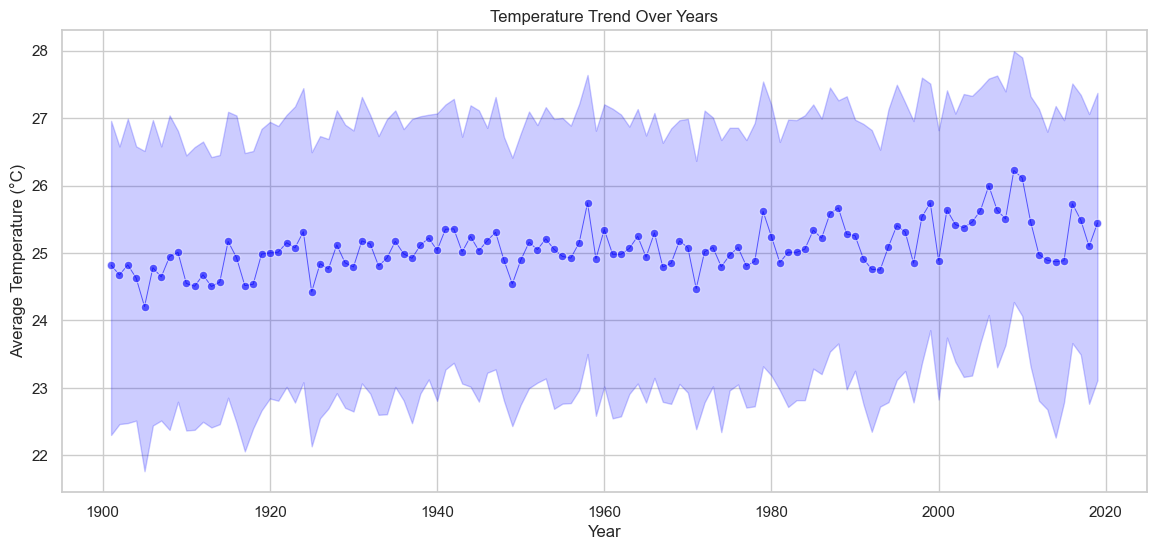

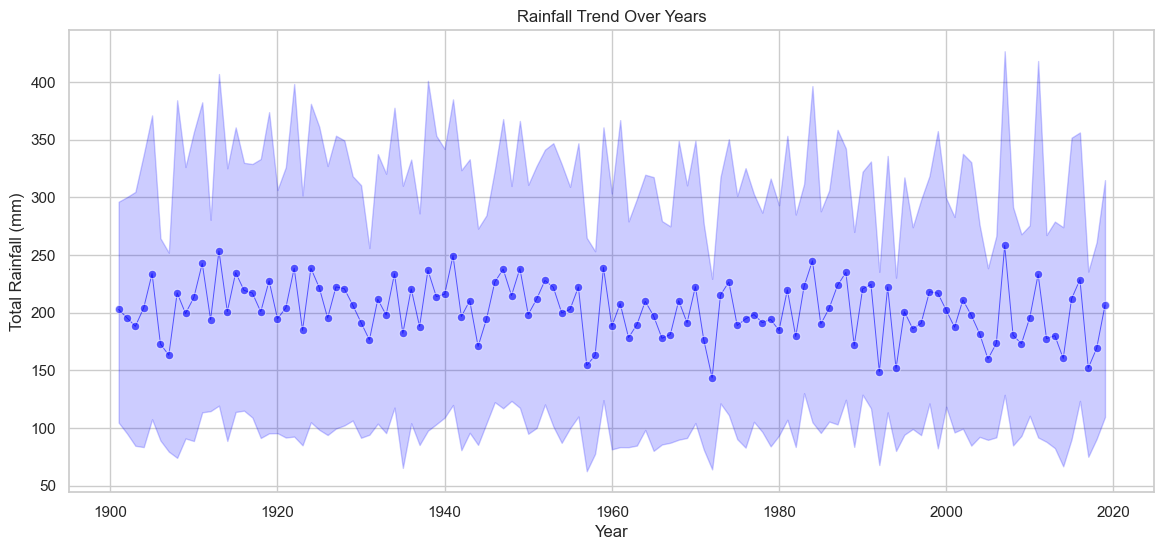

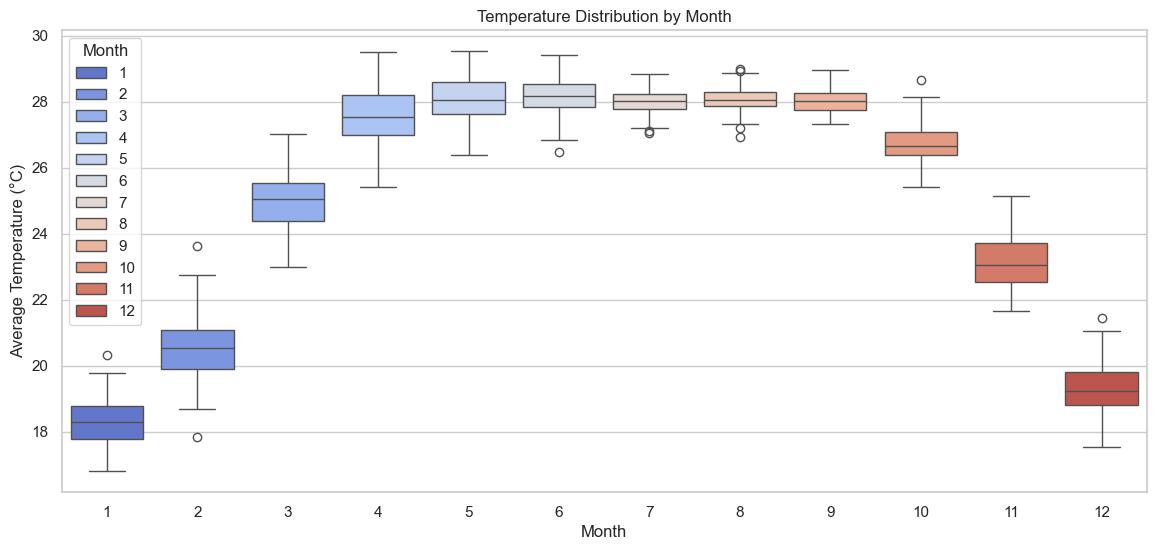

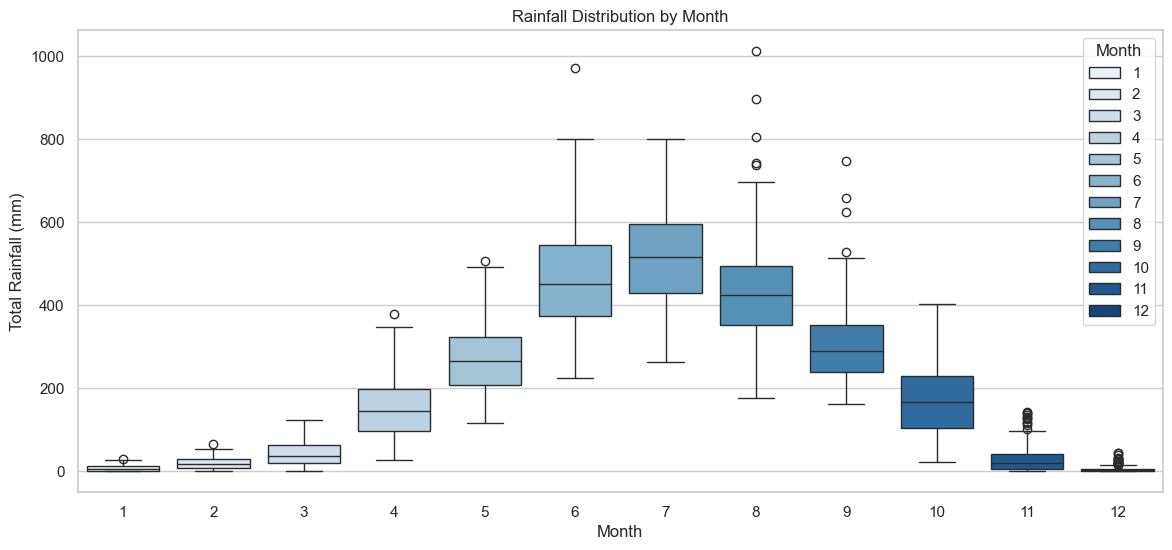

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid")

# Define plotting function for line plots
def plot_line(x, y, data, title, xlabel, ylabel, color='blue'):
    plt.figure(figsize=(14, 6))
    sns.lineplot(x=x, y=y, data=data, marker='o', alpha=0.6, linewidth=0.7, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot Temperature Trend Over Years
plot_line('Year', 'Temperature', weather_data, 'Temperature Trend Over Years', 'Year', 'Average Temperature (°C)')

# Plot Rainfall Trend Over Years
plot_line('Year', 'Rain', weather_data, 'Rainfall Trend Over Years', 'Year', 'Total Rainfall (mm)', color='blue')

# Define plotting function for boxplots
def plot_box(x, y, data, title, xlabel, ylabel, palette='coolwarm'):
    plt.figure(figsize=(14, 6))
    sns.boxplot(x=x, y=y, data=data, hue=x, palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot Temperature Distribution by Month
plot_box('Month', 'Temperature', weather_data, 'Temperature Distribution by Month', 'Month', 'Average Temperature (°C)', palette='coolwarm')

# Plot Rainfall Distribution by Month
plot_box('Month', 'Rain', weather_data, 'Rainfall Distribution by Month', 'Month', 'Total Rainfall (mm)', palette='Blues')


In [4]:
print(weather_data['Temperature'].describe())
print(weather_data['Rain'].describe())

count    1428.000000
mean       25.078908
std         3.682308
min        16.800000
25%        22.120000
50%        27.015000
75%        28.030000
max        29.530000
Name: Temperature, dtype: float64
count    1428.000000
mean      202.796317
std       201.972584
min         0.000000
25%        18.600000
50%       146.460000
75%       345.537500
max      1012.020000
Name: Rain, dtype: float64


# Feature Selection and Train-Test Split

In [5]:
# Feature selection
features = weather_data[['Year', 'Month', 'Temperature']]
features = pd.get_dummies(features, columns=['Month'], drop_first=True)  # One-hot encode categorical variables
target = weather_data['Rain']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train Random Forest Model with Hyperparameter Tuning

In [6]:
# Define parameter grid for hyperparameter tuning
param_dist = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2']
}

# Initialize Random Forest Regressor
model = RandomForestRegressor(random_state=42)

# Hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Best model after tuning
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 40}


# Evaluate the Model

Mean Squared Error: 6630.31
Mean Absolute Error: 55.88
R2 Score: 0.83


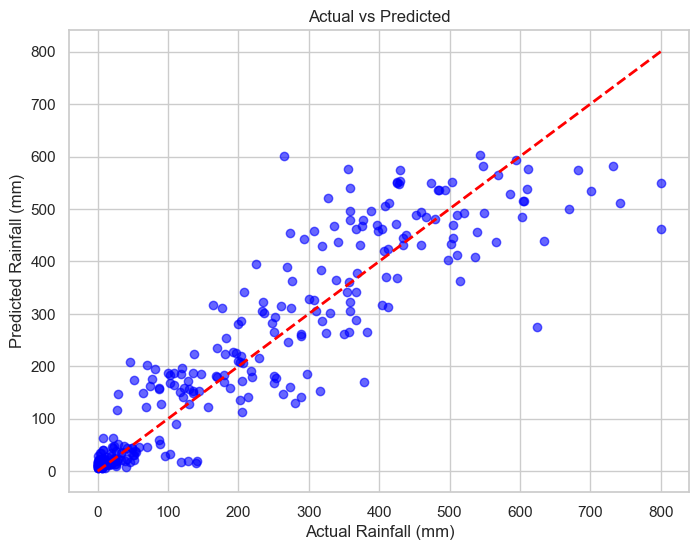

In [7]:
# Predictions on the test set
y_pred = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2)
plt.title('Actual vs Predicted')
plt.xlabel('Actual Rainfall (mm)')
plt.ylabel('Predicted Rainfall (mm)')
plt.show()


# Hypothesis

1. Temperature Influences Rainfall

In [8]:
from scipy.stats import pearsonr

# Perform Pearson correlation test
correlation, p_value = pearsonr(weather_data['Temperature'], weather_data['Rain'])

print(f"Correlation Coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: Temperature significantly influences rainfall.")
else:
    print("Fail to reject the null hypothesis: No significant relationship.")


Correlation Coefficient: 0.70
P-value: 0.0000
Reject the null hypothesis: Temperature significantly influences rainfall.


2. Trend in Rainfall Over Years

In [9]:
import statsmodels.api as sm

# Prepare the data
X = weather_data['Year']
y = weather_data['Rain']

# Add constant for the intercept
X = sm.add_constant(X)

# Perform Ordinary Least Squares (OLS) regression
model = sm.OLS(y, X).fit()

# Display regression summary
print(model.summary())

# Check p-value for the Year coefficient
if model.pvalues['Year'] < 0.05:
    print("Reject the null hypothesis: There is a significant trend in rainfall over the years.")
else:
    print("Fail to reject the null hypothesis: No significant trend in rainfall over the years.")


                            OLS Regression Results                            
Dep. Variable:                   Rain   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.228
Date:                Tue, 10 Dec 2024   Prob (F-statistic):              0.268
Time:                        20:44:15   Log-Likelihood:                -9605.1
No. Observations:                1428   AIC:                         1.921e+04
Df Residuals:                    1426   BIC:                         1.922e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        540.7510    304.983      1.773      0.0

3. Monthly Rainfall is Significantly Different

In [ ]:
from scipy.stats import f_oneway

# Group rainfall by months
groups = [weather_data[weather_data['Month'] == month]['Rain'] for month in weather_data['Month'].unique()]

# Perform ANOVA test
f_stat, p_value = f_oneway(*groups)

print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: Monthly rainfall is significantly different.")
else:
    print("Fail to reject the null hypothesis: No significant difference in monthly rainfall.")


F-statistic: 652.50
P-value: 0.0000
Reject the null hypothesis: Monthly rainfall is significantly different.


4. Visualize Hypothesis Testing Results

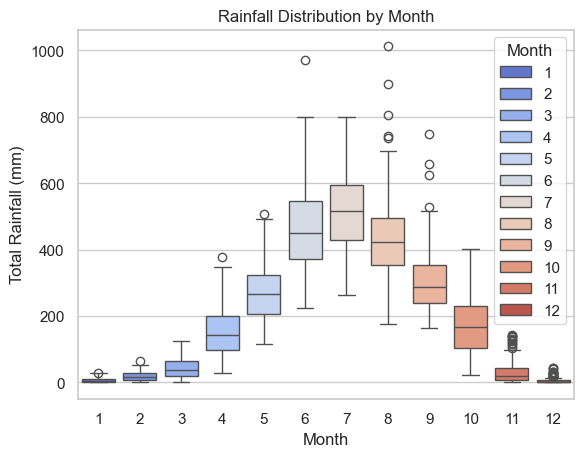

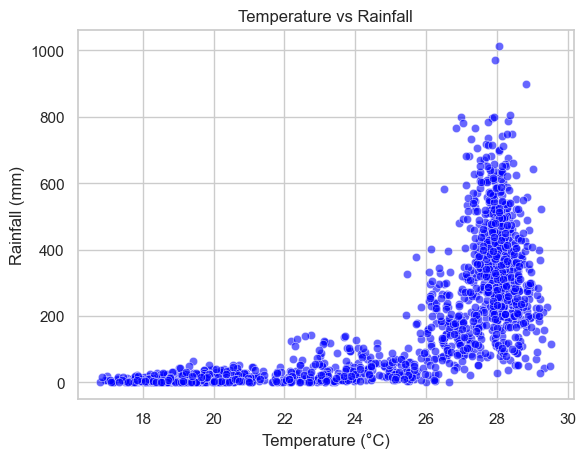

In [11]:
# Boxplot for Monthly Rainfall
sns.boxplot(x='Month', y='Rain', data=weather_data, hue='Month', palette='coolwarm')
plt.title('Rainfall Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Total Rainfall (mm)')
plt.show()

# Scatter Plot for Temperature vs Rainfall
sns.scatterplot(x='Temperature', y='Rain', data=weather_data, alpha=0.6, color='blue')
plt.title('Temperature vs Rainfall')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.show()


# Predict Rainfall for New Data

In [12]:
# Create new data for prediction
new_data = pd.DataFrame({
    'Year': [2024],
    'Month': [11],
    'Temperature': [25]
})

# One-hot encode and align columns with training data
new_data = pd.get_dummies(new_data, columns=['Month'], drop_first=True)
new_data_scaled = scaler.transform(new_data.reindex(columns=features.columns, fill_value=0))  # Align columns

# Predict rainfall
predicted_rainfall = best_model.predict(new_data_scaled)
print(f"Predicted Rainfall: {predicted_rainfall[0]:.2f} mm")


Predicted Rainfall: 56.83 mm


# Save Model and Scaler

In [13]:
import joblib

# Save the model and scaler
joblib.dump(best_model, 'rainfall_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']